# Open food facts advanced data wrangling Project

## Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import random
import seaborn as sns
import sqlite3
from matplotlib import pyplot as plt
%matplotlib inline

### A. Importing and cleaning the data

In [2]:
data_raw = pd.read_csv("en.openfoodfacts.org.products.tsv",delimiter="\t")

/Users/jasonola/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


First I import the data and create a copy of it so I don't have to reload when I make mistakes (It happened too often...)

In [3]:
data = data_raw.copy()

In [4]:
data.shape

(356027, 163)

We see that the Data is quite big, lets see how it looks like : 

In [5]:
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I feel like there is a lot of missing data, I should check that out :

In [6]:
data.isnull().sum().sum()

44183489

So I can start by removing products with no name.

In [7]:
data.dropna(subset=["product_name"],inplace=True)

Now I can check for duplicates in that column, first I put all in uppercase for better detection.

In [8]:
data.product_name = data.product_name.str.upper()
data.drop_duplicates(subset=["product_name"],inplace=True)

In [9]:
data.shape

(240284, 163)

We see that we removed more than 100000 rows like this. Now we can use this column as the index.

In [10]:
data.set_index("product_name",inplace=True)

I also fill the na values in categories as it maybe usefull later for analysis so I don't drop the column on the threshold, same for labels. (I admit I had to comeback here to keep these columns because of lack of inspiration for the questions on manipulation part)

In [11]:
data.categories_en.fillna("not available",inplace=True)

In [12]:
data.labels_en.fillna("not available", inplace=True)

Now I want to keep all columns with more than 60% non-NaN values, so I use the threshold argument. I was checking out the NaN values with `.isnull().sum()` to make sure I keep relevant columns while I was going up and down with the threshold. Then I do another threshold on the rows and finally I fill the NaN values with median for numeric values and "not available" for objects

In [13]:
data.dropna(thresh=int(data.shape[0])*0.6,axis = 1,inplace=True)

In [14]:
data.shape

(240284, 35)

Now removing columns that I dont find interesting or that has column redundancy, like keeping countries_en and taking out countries and countries_tags. I kept countries_en because it's all uniform in english, some names were in other languages for the same country and it could be problematic to compare.

In [15]:
data.drop(columns=["url","creator","brands_tags","countries","countries_tags","states","states_tags","nutrition-score-fr_100g","code","additives","created_t","last_modified_t"],inplace=True)

In [16]:
data.shape

(240284, 23)

In [17]:
data.dropna(thresh=int(data.shape[1])*0.8,axis=0,inplace=True)

In [18]:
data.shape

(180354, 23)

In [19]:
numeric_col = data.select_dtypes(include=["number"]).columns

In [20]:
data[numeric_col] = data[numeric_col].fillna(data[numeric_col].median())

In [21]:
char_col = data.select_dtypes("object").columns

In [22]:
data[char_col] = data[char_col].fillna("not available")

In [23]:
data.isnull().sum().sum()

0

In [24]:
data.shape

(180354, 23)

After all this removal I want to have a general view of my numeric columns and their general statistics so I do a describe.

In [25]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-uk_100g
count,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,1.803540e+05,180354.000000,180354.000000,180354.000000,180354.000000
mean,2.010657,0.026503,0.063797,1152.735925,12.649931,4.828136,33.071101,15.881974,4.702897e+05,7.266377,1.771034,0.697267,9.169461
std,2.600229,0.162719,0.291109,969.706257,16.318540,7.492505,28.868871,22.306922,1.997220e+08,8.427901,152.180623,59.913631,8.643337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.250000,-6.700000e+00,-800.000000,0.000000,0.000000,-14.000000
25%,0.000000,0.000000,0.000000,439.000000,0.420000,0.000000,6.670000,1.500000,2.000000e-01,1.000000,0.073660,0.029000,2.000000
50%,1.000000,0.000000,0.000000,1142.000000,6.200000,1.900000,23.300000,6.000000,1.600000e+00,5.100000,0.571500,0.225000,9.000000
75%,3.000000,0.000000,0.000000,1674.000000,20.000000,6.670000,59.380000,24.240000,3.100000e+00,10.260000,1.333500,0.525000,15.000000
max,30.000000,2.000000,6.000000,231199.000000,100.000000,550.000000,209.380000,3520.000000,8.481815e+10,430.000000,64312.800000,25320.000000,40.000000


We see that there is a negative minimum value in sugars, fiber, proteins and the score, these values are maybe related so lets see what happens if we remove the negative values from sugars_100g and fiber_100g

In [26]:
data = data[data.sugars_100g >= 0]
data = data[data.fiber_100g >= 0]

In [27]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-uk_100g
count,180349.000000,180349.000000,180349.000000,180349.000000,180349.000000,180349.000000,180349.000000,180349.000000,1.803490e+05,180349.000000,180349.000000,180349.000000,180349.000000
mean,2.010707,0.026504,0.063799,1152.748632,12.650038,4.828189,33.071811,15.882480,4.703028e+05,7.266486,1.771028,0.697265,9.169660
std,2.600247,0.162722,0.291113,969.707900,16.318622,7.492551,28.868930,22.307022,1.997248e+08,8.427983,152.182732,59.914461,8.643343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-800.000000,0.000000,0.000000,-14.000000
25%,0.000000,0.000000,0.000000,439.000000,0.420000,0.000000,6.670000,1.500000,2.000000e-01,1.000000,0.073660,0.029000,2.000000
50%,1.000000,0.000000,0.000000,1142.000000,6.200000,1.900000,23.300000,6.000000,1.600000e+00,5.100000,0.571500,0.225000,9.000000
75%,3.000000,0.000000,0.000000,1674.000000,20.000000,6.670000,59.380000,24.240000,3.100000e+00,10.260000,1.333500,0.525000,15.000000
max,30.000000,2.000000,6.000000,231199.000000,100.000000,550.000000,209.380000,3520.000000,8.481815e+10,430.000000,64312.800000,25320.000000,40.000000


We indeed removed the negative values from sugar,fiber and it automaticaly removed protein negative values somehow, but we still have our negative value from nutrition score so they are not all related. Lets see what is in nutrition score.

In [28]:
data[data["nutrition-score-uk_100g"]<0].shape

(25727, 23)

There are lots of rows with negative nutrition score, so I realise that the score is probably not just some basic multiplication of the nutrients column, so I'll leave it like that for now.

In [29]:
sum(data.energy_100g==0)

3656

I know that 0 calories food doesn't exist and 936 occurences of 0 calorie foods in my data is not much out of 100000 values so I can easily remove them.

In [30]:
data = data[data.energy_100g!=0]

In [31]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-uk_100g
count,176693.000000,176693.000000,176693.000000,176693.000000,176693.000000,176693.000000,176693.000000,176693.000000,1.766930e+05,176693.000000,176693.000000,176693.000000,176693.000000
mean,2.008727,0.027019,0.064389,1176.600449,12.907408,4.906318,33.637547,16.163682,4.800339e+05,7.415951,1.646742,0.648330,9.217066
std,2.599713,0.164254,0.292803,965.259542,16.381029,7.546742,28.742178,22.381944,2.017805e+08,8.220783,153.710890,60.516099,8.705737
min,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-14.000000
25%,0.000000,0.000000,0.000000,467.000000,0.500000,0.000000,7.140000,1.690000,3.000000e-01,1.200000,0.080000,0.031496,2.000000
50%,1.000000,0.000000,0.000000,1176.000000,6.610000,1.900000,24.200000,6.000000,1.600000e+00,5.300000,0.584200,0.230000,9.000000
75%,3.000000,0.000000,0.000000,1697.000000,20.700000,6.800000,60.000000,25.000000,3.200000e+00,10.530000,1.333500,0.525000,16.000000
max,30.000000,2.000000,6.000000,231199.000000,100.000000,550.000000,209.380000,3520.000000,8.481815e+10,430.000000,64312.800000,25320.000000,40.000000


Now I also see that most max values are over 100g for 100g which is not possible, energy is probably not in grams but 14644 cal in 100g still seems much. Let's look out for outliers.  
I first take numeric columns as numeric_data from data, then I compute the zscores in absolute value. Then I ask if the z-score is bigger than 3x the standard deviation to spot the outliers.

In [32]:
numeric_data = data.select_dtypes("number")

In [33]:
(numeric_data.drop("energy_100g",axis=1)>100).sum()

additives_n                                 0
ingredients_from_palm_oil_n                 0
ingredients_that_may_be_from_palm_oil_n     0
fat_100g                                    0
saturated-fat_100g                          2
carbohydrates_100g                          5
sugars_100g                                 4
fiber_100g                                  9
proteins_100g                               2
salt_100g                                  28
sodium_100g                                18
nutrition-score-uk_100g                     0
dtype: int64

As we can see there are a few incorrect values, lets remove them before doing the z-score.

In [34]:
data = data[data["saturated-fat_100g"]<100]
data = data[data["carbohydrates_100g"]<100]
data = data[data["sugars_100g"]<100]
data = data[data["fiber_100g"]<100]
data = data[data["proteins_100g"]<100]
data = data[data["salt_100g"]<100]
data = data[data["sodium_100g"]<100]

In [35]:
data.shape

(175047, 23)

In [36]:
numeric_data = data.select_dtypes("number")

In [37]:
filter_all = np.abs(numeric_data-numeric_data.mean())>(3*numeric_data.std())

I got my filter, now I want to spot the rows that have any outliers.

In [38]:
filter_any = filter_all.any(axis=1)

In [39]:
filter_any.sum()

28212

In [40]:
outliers = data.loc[filter_any, :]
outliers.shape

(28212, 23)

We see that there are 28212 outliers, we can remove them from the data

In [41]:
data.drop(outliers.index,inplace=True)

In [42]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-uk_100g
count,146835.000000,146835.0,146835.0,146835.000000,146835.000000,146835.000000,146835.000000,146835.000000,146835.000000,146835.000000,146835.000000,146835.000000,146835.000000
mean,1.666319,0.0,0.0,1082.174189,11.392968,4.294179,31.752221,14.413138,2.348182,7.191496,0.923855,0.363728,8.576824
std,1.976177,0.0,0.0,717.025893,13.066196,5.896018,27.793851,18.154776,2.707552,7.001276,1.177113,0.463425,8.749017
min,0.000000,0.0,0.0,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.000000
25%,0.000000,0.0,0.0,402.000000,0.500000,0.000000,6.670000,1.600000,0.200000,1.500000,0.088900,0.035000,1.000000
50%,1.000000,0.0,0.0,1046.000000,5.930000,1.900000,20.500000,5.930000,1.600000,5.360000,0.600000,0.236220,9.000000
75%,3.000000,0.0,0.0,1644.000000,20.000000,6.060000,57.690000,21.820000,3.200000,10.710000,1.320000,0.519685,15.000000
max,9.000000,0.0,0.0,3556.000000,62.100000,27.140000,99.800000,75.000000,14.600000,31.820000,10.441940,4.111000,35.000000


We see in the describe table that indeed the maximum values are more reasonable. I'm not sure though how I should treat the 0 minimum values as they are not necessarly impossible, I ploted histograms for the numerical columns (here is one below for fiber for example) and they seemed ok so I guess I'll keep them like this. Also we see that palm oil columns got empty after the outliers drop so we delete them

In [43]:
data.drop(["ingredients_from_palm_oil_n","ingredients_that_may_be_from_palm_oil_n"],axis = 1, inplace=True)

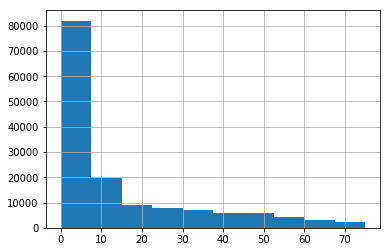

In [44]:
data.sugars_100g.hist();

I would remove states_en and nutrition_grade_fr because they look useless, also we saw in the describe that after our outliers manipulation, both the palm oil columns have no values anymore apart from 0 so I remove them as well.  
Also changing the countries_en column to lists instead of just strings

In [45]:
data.countries_en = data.countries_en.str.split(",")

Lets have a view of our data :

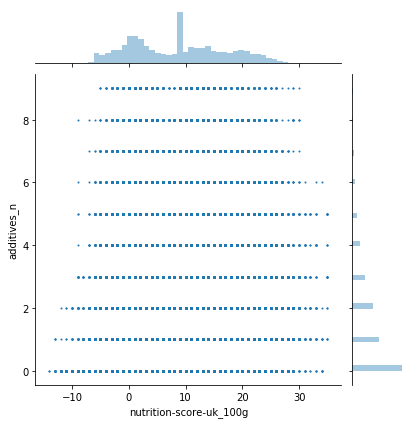

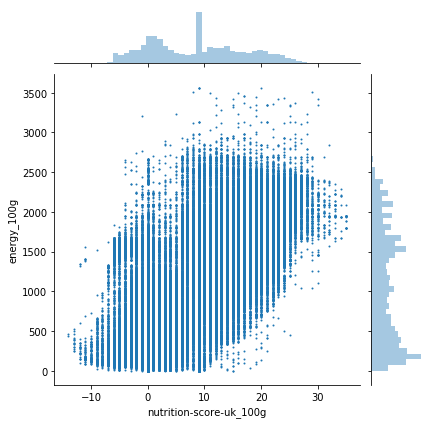

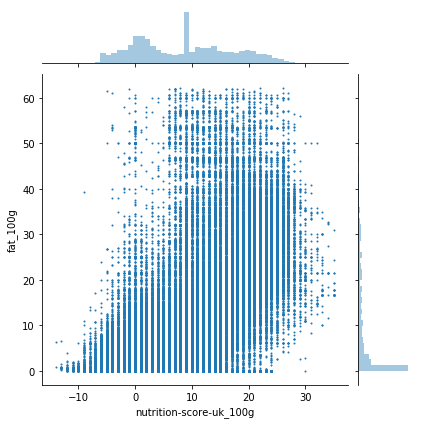

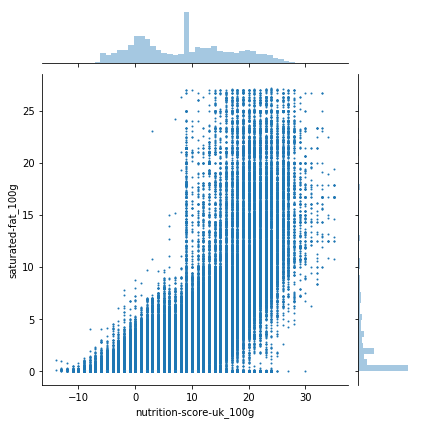

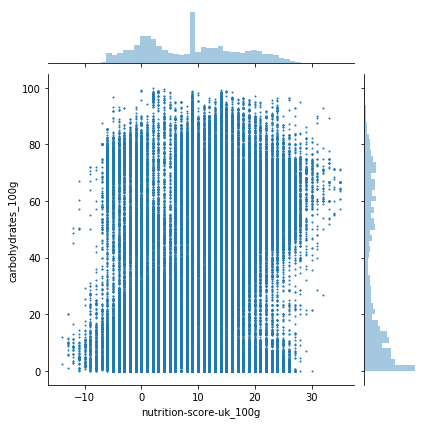

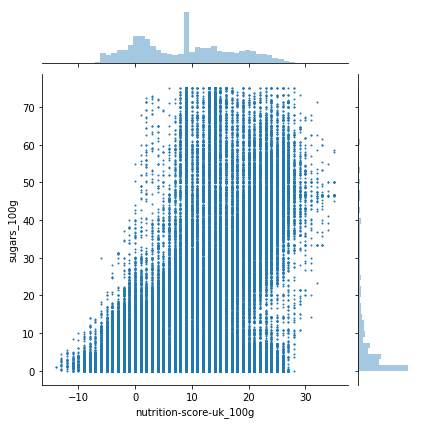

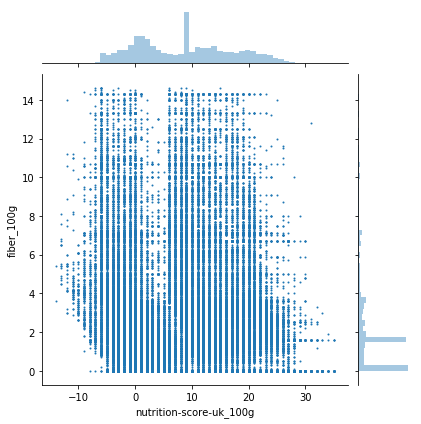

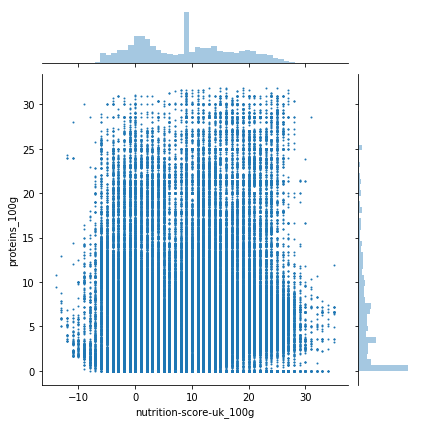

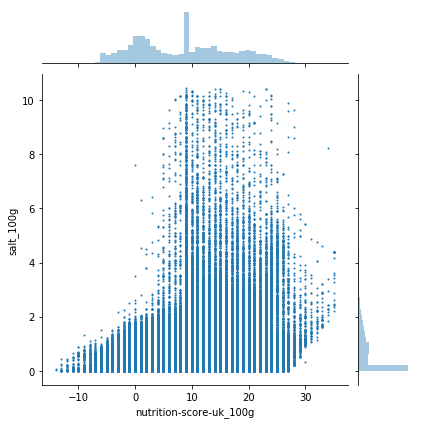

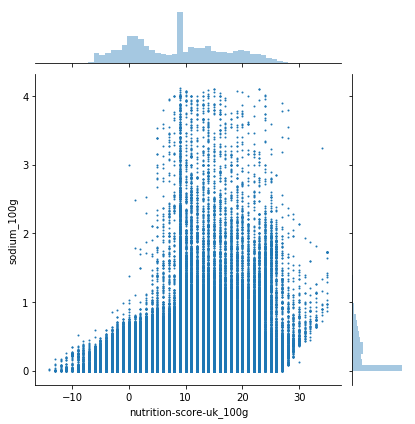

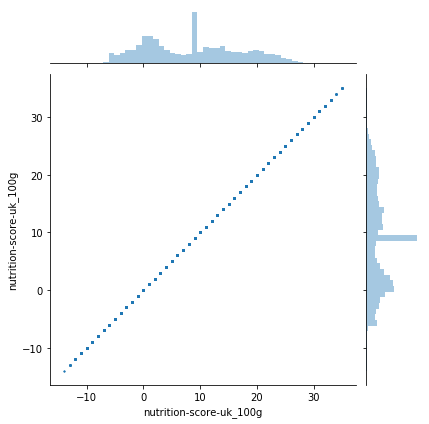

In [46]:
import seaborn as sns
for col in data.select_dtypes(np.number).keys():
    sns.jointplot(data['nutrition-score-uk_100g'], col, data=data, height=6, s=1)
    plt.show()

Now the data looks clean enough to me for analysis ! 

### B. Manipulating the data

#### What is the average composition like for each country ?
I would like some insights about the 3 macronutrients : protein, carbs and fat. So I make a data subset of these for ease of reading.  
These are the main components of different foods so we can make comparison of compositions in different meals


In [47]:
macronut = data[["countries_en","proteins_100g","carbohydrates_100g","fat_100g","categories_en"]]
meals = macronut[macronut.categories_en.str.contains("(M|m)eal")]

/Users/jasonola/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


First I explode the countries (I had to update my pandas from 0.25 to 1.03 to use this method)

In [48]:
countries = meals.explode("countries_en")

In [49]:
countries.countries_en = countries.countries_en.str.replace("fr:Deutschland","Germany")
countries.countries_en = countries.countries_en.str.replace("French Guiana","France")
countries.countries_en = countries.countries_en.str.replace("Saint Pierre and Miquelon","France")
countries.countries_en = countries.countries_en.str.replace("Réunion","France")
countries.countries_en = countries.countries_en.str.replace("Guadeloupe","France")

In [50]:
countries = countries[countries.countries_en != "not available"]

In [51]:
by_country = countries.groupby("countries_en")

In [52]:
mean_by_countries = by_country.mean()

Now I can see the mean composition of main macronutrients by country.

I then make the columns in percent.

In [53]:
mean_by_countries = mean_by_countries.div(mean_by_countries.sum(axis=1),axis=0)*100

And now I plot the result :

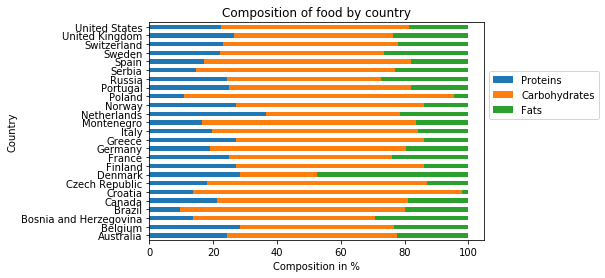

In [54]:
mean_by_countries.plot(kind="barh",stacked=True)
plt.title("Composition of food by country")
plt.legend(["Proteins","Carbohydrates","Fats"],bbox_to_anchor=(1, 0.8))
plt.xlabel("Composition in %")
plt.ylabel("Country");

We see in the graph that most common macronutrient is carbohydrates 

Now let's look at other insights. I heard eating too much salt was bad for health (high blood pressure, strokes...) so I did a little research and found out that having 1.5g or more salt per 100g of food was considered too much. 
https://www.bhf.org.uk/informationsupport/support/healthy-living/healthy-eating/salt
#### Are we eating too much salt ?
Let's check how much salt we have in our meals

In [55]:
meals["salt_100g"] = data.salt_100g

/Users/jasonola/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


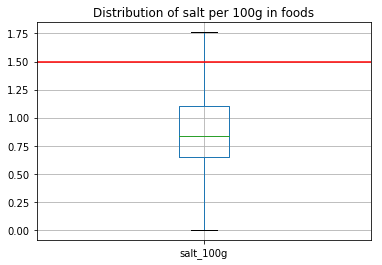

In [56]:
salt = meals[["countries_en","salt_100g"]]
salt.boxplot(showfliers = False)
plt.axhline(y=1.5,color = "red")
plt.title("Distribution of salt per 100g in foods");

We see that most values lie between 0.6 and 1, the distribution shows reasonable amounts of salt. Let's look by country.

In [57]:
salt = salt.explode("countries_en")

In [58]:
salt_by_country = salt.groupby("countries_en")
salt_by_country.describe()

salt_100g                                          \
                              count       mean       std      min       25%   
countries_en                                                                  
Australia                      17.0   1.080914  1.402901   0.0127   0.59182   
Belgium                        34.0   0.836406  0.366793   0.2540   0.58500   
Bosnia and Herzegovina          1.0  10.100000       NaN  10.1000  10.10000   
Brazil                          3.0   8.903333  0.716543   8.4600   8.49000   
Canada                          6.0   1.069833  0.356242   0.4990   0.95000   
Croatia                         1.0   0.800000       NaN   0.8000   0.80000   
Czech Republic                  2.0   1.400000  0.707107   0.9000   1.15000   
Denmark                         2.0   0.905000  1.265721   0.0100   0.45750   
Finland                         1.0   1.800000       NaN   1.8000   1.80000   
France                       4166.0   0.930982  0.623812   0.0000   0.65000   
French Guiana                   4.0   0.847700  0.267043   0.6096   0.68580   
Germany                       131.0   1.112136  0.753321   0.0100   0.80000   
Greece                          1.0   1.800000       NaN   1.8000   1.80000   
Guadeloupe                     11.0   0.733402  0.264900   0.3048   0.56500   
Italy                           3.0   1.149533  0.303333   0.9500   0.97500   
Montenegro                      1.0   0.800000       NaN   0.8000   0.80000   
Netherlands                     9.0   0.993333  0.460814   0.4000   0.70000   
Norway                          1.0   1.800000       NaN   1.8000   1.80000   
Poland                          1.0   0.950000       NaN   0.9500   0.95000   
Portugal                        9.0   1.526664  0.833651   0.9800   1.00076   
Russia                          1.0   0.880000       NaN   0.8800   0.88000   
Réunion                         2.0   0.910000  0.551543   0.5200   0.71500   
Saint Pierre and Miquelon       1.0   0.747000       NaN   0.7470   0.74700   
Serbia                         14.0   2.190000  3.353453   0.6400   0.81000   
Spain                         198.0   0.835370  0.981370   0.0000   0.46040   
Sweden                         51.0   0.834706  0.279974   0.0100   0.64000   
Switzerland                   175.0   1.159353  0.754945   0.1000   0.80000   
United Kingdom                 90.0   0.839072  0.971451   0.0000   0.50200   
United States                  19.0   1.135974  0.621800   0.5260   0.77550   
fr:Deutschland                  2.0   5.250000  5.868986   1.1000   3.17500   
not available                   1.0   0.770000       NaN   0.7700   0.77000   

                                                          
                                50%       75%        max  
countries_en                                              
Australia                   0.83058   0.94488   6.350000  
Belgium                     0.71500   0.99695   1.900000  
Bosnia and Herzegovina     10.10000  10.10000  10.100000  
Brazil                      8.52000   9.12500   9.730000  
Canada                      1.05000   1.31500   1.500000  
Croatia                     0.80000   0.80000   0.800000  
Czech Republic              1.40000   1.65000   1.900000  
Denmark                     0.90500   1.35250   1.800000  
Finland                     1.80000   1.80000   1.800000  
France                      0.82600   1.10000  10.160000  
French Guiana               0.78060   0.94250   1.220000  
Germany                     0.95000   1.25000   7.100000  
Greece                      1.80000   1.80000   1.800000  
Guadeloupe                  0.70000   0.88490   1.143000  
Italy                       1.00000   1.24930   1.498600  
Montenegro                  0.80000   0.80000   0.800000  
Netherlands                 1.03000   1.50000   1.600000  
Norway                      1.80000   1.80000   1.800000  
Poland                      0.95000   0.95000   0.950000  
Portugal                    1.23000   1.6

Let's compare the 3 countries with the most count so it can be somewhat relevant : France, Switzerland and Spain

In [59]:
salt_3countries = salt[salt.countries_en.str.contains("France|Switzerland|Spain")].groupby("countries_en")

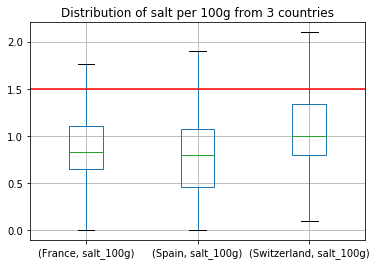

In [60]:
salt_3countries.boxplot(subplots=False,showfliers=False)
plt.axhline(y=1.5,color = "red")
plt.title("Distribution of salt per 100g from 3 countries");

We see that in Switzerland, food tends to be more salty over all as most of the distribution lie between 0.8 and 1.4 which is close to our critical value, we might need to be careful of what we eat !

When I see the labels column I see a good amount of vegetarian food and some vegan too, maybe there is enough data to work with.  
Vegans are often asked if their input of protein is enough as main source of protein traditionally comes from meat.  
Let's compare the proteins per 100g of vegan food and meats.

In [61]:
vegan = data[data.labels_en.str.contains("(V|v)egan")]

/Users/jasonola/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [62]:
meat = data[data.categories_en.str.contains("(M|m)eat")]

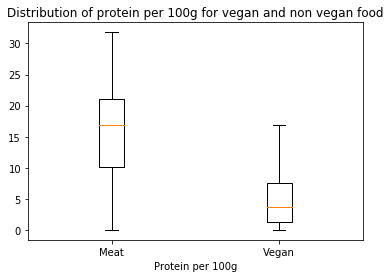

In [63]:
plt.boxplot([meat.proteins_100g,vegan.proteins_100g],showfliers=False)
plt.xticks([1,2],["Meat","Vegan"])
plt.title("Distribution of protein per 100g for vegan and non vegan food")
plt.xlabel("Protein per 100g");

We see that meat has indeed more protein in general. Let's look at what are the highest protein vegan foods.

In [64]:
top_15_vegan_prot = vegan.proteins_100g.sort_values(ascending=False).head(15)

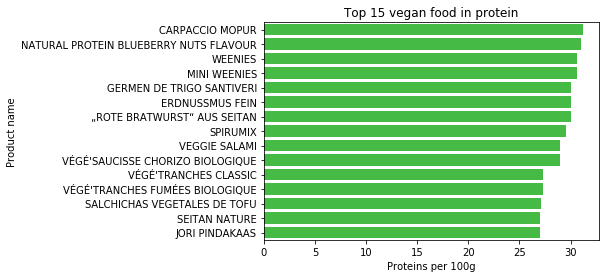

In [65]:
sns.barplot(top_15_vegan_prot,top_15_vegan_prot.index,color = "limegreen")
plt.title("Top 15 vegan food in protein")
plt.xlabel("Proteins per 100g")
plt.ylabel("Product name");

### C. Text data

So my idea is to convert this ingredients columns from text to list then I can unnest it and then count everything. So first I remove the parenthesis and then I make the lists by spliting on commas. 
I put the ingredients in upperstring and replace all the space by only one space so they are all on the same count and to avoid having some ingredients wrongly doubled because of multiple spaces in the string that are not supposed to be there. Then I take the 5 first element starting from index 1 to omit all the spaces and voila.


In [66]:
list_ingredients = pd.DataFrame(data.ingredients_text.str.replace("\(|\)",",").str.replace("\.","").str.replace("\s+","").str.split(","))

In [67]:
exploded_list = pd.DataFrame(list_ingredients.explode("ingredients_text").ingredients_text.str.upper())

In [68]:
exploded_list.ingredients_text = exploded_list.ingredients_text.str.replace("SEL","SALT")
exploded_list.ingredients_text = exploded_list.ingredients_text.str.replace("EAU","WATER")
exploded_list.ingredients_text = exploded_list.ingredients_text.str.replace("SUCRE","SUGAR")

In [69]:
top_5_ingredients = pd.DataFrame(exploded_list.groupby("ingredients_text").size().sort_values(ascending=False).iloc[1:6])

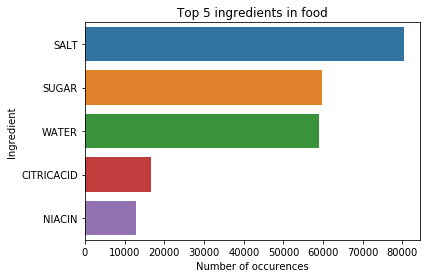

In [70]:
sns.barplot(top_5_ingredients[0],top_5_ingredients.index)
plt.title("Top 5 ingredients in food")
plt.xlabel("Number of occurences")
plt.ylabel("Ingredient");

### D. Time-series analysis

Let's create a time dataframe from the raw data to have all values.

In [71]:
time_data = data_raw[["created_datetime","last_modified_datetime"]].copy()

In [72]:
time_data.dropna(inplace=True)

I see that the datetimes are not in the right format so I convert them to datetime and I pass the argument to coerce if it doesn't recognise a date. It will put NaN values in place instead of an error so I can simply remove the dates with dropna

In [73]:
time_data.created_datetime = pd.to_datetime(time_data.created_datetime,errors="coerce")
time_data.last_modified_datetime = pd.to_datetime(time_data.last_modified_datetime,errors="coerce")

In [74]:
time_data.isnull().sum()

created_datetime          17
last_modified_datetime    17
dtype: int64

I see there are only 17 not converted rows so I feel confortable droping them.

In [75]:
time_data.dropna(inplace=True)

Now we have a nice table for time analysis  
Let's compute the time delta first, i'll create a column for it.

In [76]:
time_data["time_delta"] = time_data.last_modified_datetime - time_data.created_datetime

Now let's get the mean of these deltas

In [77]:
time_data.time_delta.describe()

count                      356000
mean     108 days 03:35:07.638426
std      283 days 13:39:56.859215
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:01
75%        8 days 18:31:35.250000
max            2033 days 13:40:59
Name: time_delta, dtype: object

We see that there is a mean of 108 days, however I noticed that 50% of the differences are below 1 second and the standard deviation is very high so it's not really significative.

In [78]:
time_data.set_index("created_datetime",inplace=True)

Now I can "groupby" month using resample and count the number of occurences.

In [79]:
counts_per_month = time_data.resample("M").count()

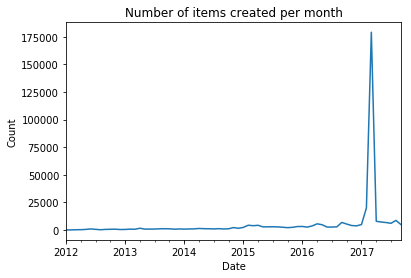

In [80]:
counts_per_month.drop("time_delta",axis=1).rename(columns={"last_modified_datetime":"count"}).plot(legend=False)
plt.title("Number of items created per month")
plt.xlabel("Date")
plt.ylabel("Count");

We see that there is a big spike early in 2017 and nothing much before and after that spike. Lets do a Log to see the low values more in detail

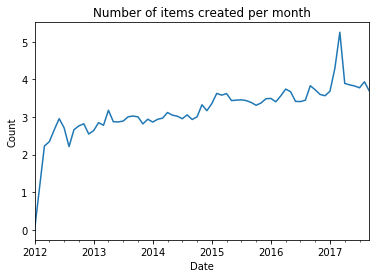

In [81]:
np.log10(counts_per_month.drop("time_delta",axis=1).rename(columns={"last_modified_datetime":"count"})).plot(legend=False)
plt.title("Number of items created per month")
plt.xlabel("Date")
plt.ylabel("Count");

### E. Build a database


* Restrict your data to 1000 entries and 5 columns of your choice  


Taking a sample of 1000 from the data and choosing the macronutrients columns and export that table to csv

In [82]:
restricted_data = data.reset_index().sample(1000)[["product_name","energy_100g","fat_100g","carbohydrates_100g","proteins_100g"]]

In [83]:
restricted_data.to_csv("macronutrients.csv",index=False)

* Create a connection to a sqlite3 database

In [84]:
db = sqlite3.connect("openfood.db")

* Create one or multiple tables, at least one of the tables should have a PRIMARY KEY  

Writing a query to create the table in the database and then execute that query

In [85]:
cursor = db.cursor()

In [86]:
query = """
            CREATE TABLE macronutrients 
            (id INTEGER PRIMARY KEY, 
            product_name TEXT, 
            energy_100g FLOAT, 
            fat_100g FLOAT, 
            carbohydrates_100g FLOAT, 
            proteins_100g FLOAT);
        """
         

In [87]:
cursor.execute(query)

* Fill the database with your data

Doing a for loop to fill the database by chunk of 10 rows from the csv

In [88]:
for chunk in pd.read_csv("macronutrients.csv", chunksize=10):
    chunk.to_sql(name="macronutrients", con=db, if_exists="append", index=False)  

* Run at least one query to demonstrate that it works correctly

Let's get the 3 first elements from the database :

In [89]:
cursor.execute("SELECT * FROM macronutrients LIMIT 3")

In [90]:
cursor.fetchall()

[(1, 'WAVE, BERRY MEDLEY WITH WHITE CRANBERRIES', 134.0, 0.0, 8.37, 0.0),
 (2,
  'HONEY OATS & FLAKES, WITH ALMONDS, TOASTED MULTI-GRAIN CEREAL, WITH ALMONDS & HONEY OAT CLUSTERS',
  1674.0,
  5.0,
  83.33,
  6.67),
 (3, 'GOURMET SANDWICHES', 703.0, 9.09, 6.29, 15.38)]

### F. Finding correlations

Let's look for the most correlated variable to nutrition score. First I compute the correlations between each numerical variable in the data. Then I make a heatmap to spot quickly the highest correlation with the nutrition score. 

In [91]:
corr = data.corr()

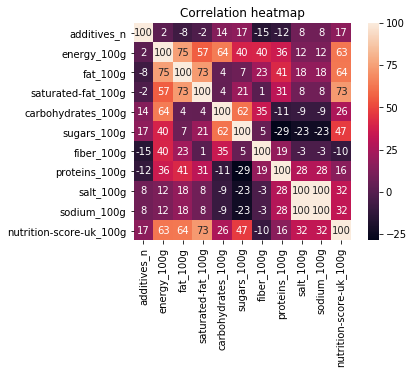

In [92]:
sns.heatmap(corr*100, square=True, annot=True, fmt='.0f')
plt.title("Correlation heatmap");

I see that the closest value to 100 is the saturated fat with 73, followed by energy and fat. Saturated fat is known to be bad for health if abused. Seeing that sugar is also mediumly correlated, I guess the nutritional score is high if the food is bad for health. The more fat and energy, the higher the score.

In [93]:
corr["nutrition-score-uk_100g"].sort_values(ascending=False).tail(10).head(3)

saturated-fat_100g    0.731449
fat_100g              0.636514
energy_100g           0.629224
Name: nutrition-score-uk_100g, dtype: float64